In [1]:
import chardet
import os
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD   
from nltk.tokenize import word_tokenize
import nltk
from fuzzywuzzy import fuzz
import random
import time
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import seaborn as sns


/Users/wally/anaconda3/envs/3350/lib/python3.11/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# 1. Data Importing and Cleaning

In [2]:
def detect_encoding(file_path):
    with open(file_path, 'rb') as file:
        raw_data = file.read()

    result = chardet.detect(raw_data)
    return result['encoding']

def srt_to_text(srt_file_path):
    encoding_attempts = ['utf-8', 'ISO-8859-1', 'utf-16', ]

    for encoding in encoding_attempts:
        try:
            with open(srt_file_path, 'r', encoding=encoding) as file:
                lines = file.readlines()

            text = ""
            current_line = ""
            is_time_line = True

            for line in lines:
                line = line.strip()

                if not line:
                    is_time_line = True
                    continue

                if is_time_line:
                    is_time_line = False
                    continue

                current_line += line + " "

                # If the line ends with a punctuation indicating the end of a sentence
                if line.endswith(('.', '!', '?')):
                    text += current_line + "\n"
                    current_line = ""

            return text.strip()
        except UnicodeDecodeError:
            None

    # If none of the encodings work
    print(f"Unable to decode file: {srt_file_path}")
    return None

def process_srt_files_in_folder(folder_path):
    result_dict = []

    for filename in os.listdir(folder_path):
        if filename.endswith(".srt"):
            srt_file_path = os.path.join(folder_path, filename)
            text_content = srt_to_text(srt_file_path)

            if text_content is not None:
                file_dict = {"name": filename, "text": text_content}
                result_dict.append(file_dict)

    return result_dict

# Example usage for a folder containing SRT files
wally = '/Users/wally/Library/CloudStorage/OneDrive-Personal/Documents/Cornell/1. Fourth Year/INFO 6350 - Text Mining History and Literature/INFO6350_Final_Project/Wally/srt_files'
casey = '/Users/caseykaufman/Documents/GitHub/INFO6350_Final_Project/srt_files'

folder_path = wally

result_dictionary = process_srt_files_in_folder(folder_path)

In [3]:
movie_subtitles_df = pd.DataFrame(result_dictionary)

In [4]:
# Removal of timestamps
movie_subtitles_df['text'] = movie_subtitles_df['text'].str.replace(r'\d{2}:\d{2}:\d{2},\d{3} --> \d{2}:\d{2}:\d{2},\d{3}[\s-]+', '\n', regex=True)
movie_subtitles_df['text'] = movie_subtitles_df['text'].str.replace(r'<font.*?>|<\/font>', '', regex=True)
movie_subtitles_df['text'] = movie_subtitles_df['text'].str.replace(r'\bdownloaded.*?|subtitles downloaded.*?|http.*?|www.*?', '', regex=True, flags=re.IGNORECASE)

In [5]:
pd.options.display.max_rows = 400

In [6]:
# Find the year of each movie from the file name
years = []
for name_index in range(len(movie_subtitles_df['name'])):
    found_year = False
    for letter_index in range(len(movie_subtitles_df['name'][name_index])):
        if movie_subtitles_df['name'][name_index][letter_index:letter_index+2] == '19' and movie_subtitles_df['name'][name_index][letter_index:letter_index+4].isdigit() or movie_subtitles_df['name'][name_index][letter_index:letter_index+2] == '20' and movie_subtitles_df['name'][name_index][letter_index:letter_index+4].isdigit():
            y = movie_subtitles_df['name'][name_index][letter_index:letter_index+4]
            years.append(y)
            found_year = True
            break
    if not found_year:
        years.append('na')

# Add new column with corresponding years
movie_subtitles_df['years'] = years

In [7]:
#cleaning names
pattern1= r'^([^\d(]+)(?:\.\d{4}| \(\d{4}\))?\.?[^\w]*'
pattern2 = r'^[^a-zA-Z]*(.*?)\.[a-zA-Z]{3}\b'
pattern3 = r'^[^a-zA-Z]*(.*?)\.[a-zA-Z]{3}-'

clean_names = []
for file_name in movie_subtitles_df['name']:
    match = re.match(pattern1, file_name) or re.match(pattern2, file_name) or re.match(pattern3, file_name)
    if match:
        extracted_name = match.group(1).replace('.', ' ')
        clean_names.append(extracted_name)
    else:
        print("Name extraction pattern not found for:", file_name)
        
new = [name.split('WWW')[0].strip() if 'WWW' in name else name for name in clean_names]
clean_names = [x.replace('-','') for x in new]

In [8]:
movie_subtitles_df['Movie Name'] = clean_names

In [9]:
#adding win/loss
excel = pd.read_csv('scripts.csv')

#getting index values
highest = []
for films in clean_names: 
    similarity = []
    indexes = []
    for all_films in excel['Film']:
        sim = fuzz.ratio(str(films), str(all_films))
        similarity.append(sim)
    highest.append(similarity.index(max(similarity)))
    
movie_name_check = []
win_loss = []
for idx in highest:
    value1 = excel.loc[idx,'Film']
    value2 = excel.loc[idx,'Win']
    movie_name_check.append(value1)
    win_loss.append(value2)
    
movie_subtitles_df['Similarity Calc Name'] = movie_name_check
movie_subtitles_df['Win or Loss'] = win_loss

In [10]:
movie_subtitles_df.head()

,name,text,years,Movie Name,Similarity Calc Name,Win or Loss
0,Sunset Blvd. (1950)_english.srt,"\nYes, this is Sunset Boulevard, Los Angeles, ...",1950,Sunset Blvd,Sunset Boulevard,1.0
1,Diner.1982.720p.BluRay.x264-AMIABLE.srt,\nA little bit softer now - Shout \nA little b...,1982,Diner,Diner,0.0
2,Road.To.Utopia.1945.1080p.BluRay.x264-[YTS.AM]...,"\nFor those of you who don't go to the movies,...",1945,Road To Utopia,Road to Utopia,0.0
3,Tender Mercies (1983).srt,"\nHere, give me the bottle. \n- Go to hell. \n...",1983,Tender Mercies,Tender Mercies,1.0
4,Ghandi.1982.1080p.BluRay.x264.YIFY.srt,\nThere are more than yesterday. \n\nHe will b...,1982,Ghandi,Gandhi,1.0


In [11]:
# Tokenize the text in each row
tokenized_text = movie_subtitles_df['text'].apply(word_tokenize)

# Add the tokenized text to a new column
movie_subtitles_df['tokenized_text'] = tokenized_text

# 2. Basic Data Exploration and Pre-Processing

## Create Vectorizers

In [12]:
# TFIDF Vectorizer with idf on
tfidf_vectorizer = TfidfVectorizer(use_idf=True, norm=None)

## Count Tokens in Each Movie Script

In [13]:
# Add the number of tokens in a movie script to a new column titled 'num_tokens'
movie_subtitles_df['num_tokens'] = [len(movie_subtitles_df['tokenized_text'][i]) for i in range(len(movie_subtitles_df['text']))]

In [14]:
movie_subtitles_df.head()

,name,text,years,Movie Name,Similarity Calc Name,Win or Loss,tokenized_text,num_tokens
0,Sunset Blvd. (1950)_english.srt,"\nYes, this is Sunset Boulevard, Los Angeles, ...",1950,Sunset Blvd,Sunset Boulevard,1.0,"[Yes, ,, this, is, Sunset, Boulevard, ,, Los, ...",15458
1,Diner.1982.720p.BluRay.x264-AMIABLE.srt,\nA little bit softer now - Shout \nA little b...,1982,Diner,Diner,0.0,"[A, little, bit, softer, now, -, Shout, A, lit...",16868
2,Road.To.Utopia.1945.1080p.BluRay.x264-[YTS.AM]...,"\nFor those of you who don't go to the movies,...",1945,Road To Utopia,Road to Utopia,0.0,"[For, those, of, you, who, do, n't, go, to, th...",15171
3,Tender Mercies (1983).srt,"\nHere, give me the bottle. \n- Go to hell. \n...",1983,Tender Mercies,Tender Mercies,1.0,"[Here, ,, give, me, the, bottle, ., -, Go, to,...",9986
4,Ghandi.1982.1080p.BluRay.x264.YIFY.srt,\nThere are more than yesterday. \n\nHe will b...,1982,Ghandi,Gandhi,1.0,"[There, are, more, than, yesterday, ., He, wil...",15581


#### Number of Tokens by Year

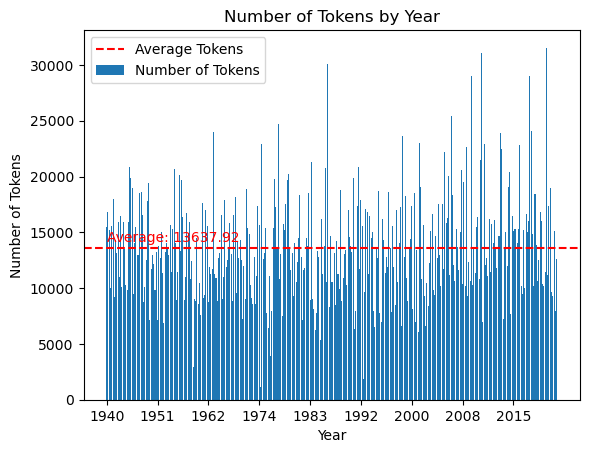

In [15]:
import matplotlib.pyplot as plt

# Sort DataFrame by 'years' in ascending order
movie_subtitles_df = movie_subtitles_df.sort_values(by='years')

# Set x-axis ticks to show only once every other 20 years
step = 40  # Adjust the step value as needed
plt.xticks(range(0, len(movie_subtitles_df['years']), step), movie_subtitles_df['years'][::step])

# Create bar chart
plt.bar(movie_subtitles_df.index, movie_subtitles_df['num_tokens'], label='Number of Tokens')
plt.xlabel('Year')
plt.ylabel('Number of Tokens')
plt.title('Number of Tokens by Year')

# Plot the average line
average_tokens = movie_subtitles_df['num_tokens'].mean()
plt.axhline(y=average_tokens, color='red', linestyle='--', label='Average Tokens')

# Display the average value
plt.text(0.5, average_tokens + 500, f'Average: {average_tokens:.2f}', color='red', ha='left')

plt.legend()
plt.show()

#### Minimum number of tokens vs maximum number of tokens

Minimum number of tokens in all scripts:  1125
Maximum number of tokens in all scripts:  31547


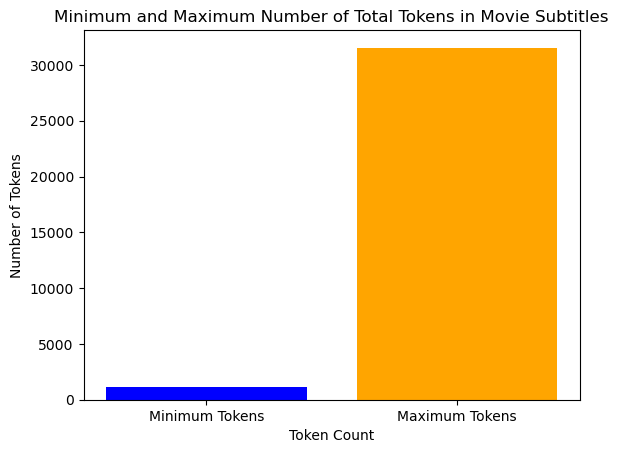

In [16]:
# Minimum number of tokens versus maximum number of tokens
min_tokens = min(movie_subtitles_df['num_tokens'])
max_tokens = max(movie_subtitles_df['num_tokens'])

print('Minimum number of tokens in all scripts: ', min_tokens)
print('Maximum number of tokens in all scripts: ', max_tokens)

# Plotting the data
labels = ['Minimum Tokens', 'Maximum Tokens']
values = [min_tokens, max_tokens]

plt.bar(labels, values, color=['blue', 'orange'])
plt.xlabel('Token Count')
plt.ylabel('Number of Tokens')
plt.title('Minimum and Maximum Number of Total Tokens in Movie Subtitles')
plt.show()

#### Longest paragraph/line versus shortest paragraph/line, split on line breaks

Longest Paragraph length: 
284

Shortest Paragraph length: 
2


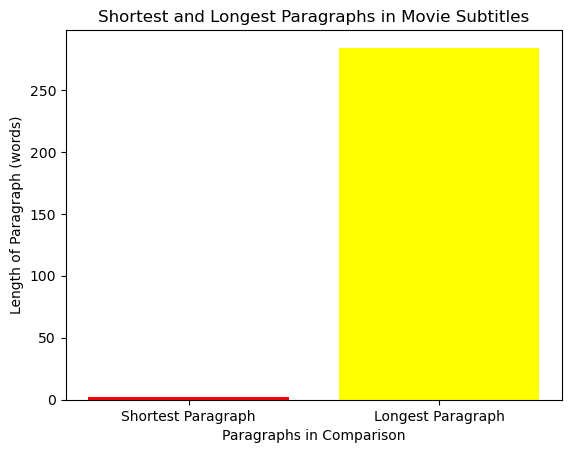

In [17]:
# Find the longest and shortest paragraphs
max_length = 0
min_length = 100000000
longest_paragraph = ''
shortest_paragraph = ''

for index, row in movie_subtitles_df.iterrows():
    paragraphs = row['text'].split('\n')  # Assuming paragraphs are separated by '\n'
    
    for paragraph in paragraphs:
        paragraph_length = len(paragraph)
        
        # Update longest paragraph
        if paragraph_length > max_length:
            max_length = paragraph_length
            longest_paragraph = paragraph

        # Update shortest paragraph
        if paragraph_length < min_length and paragraph.strip():  # Check for non-empty paragraphs
            min_length = paragraph_length
            shortest_paragraph = paragraph

print("Longest Paragraph length: ")
print(len(longest_paragraph))

print("\nShortest Paragraph length: ")
print(len(shortest_paragraph))

# Plotting the data
labels = ['Shortest Paragraph', 'Longest Paragraph']
values = [len(shortest_paragraph), len(longest_paragraph)]

plt.bar(labels, values, color=['red', 'yellow'])
plt.xlabel('Paragraphs in Comparison')
plt.ylabel('Length of Paragraph (words)')
plt.title('Shortest and Longest Paragraphs in Movie Subtitles')
plt.show()

#### See Cosine Similarity Scores Between Movies

In [18]:
# Create a TF-IDF vectorizer to conduct similarity test with stop word removal
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(movie_subtitles_df['text'])

# Compute cosine similarity between movies
similarity_matrix = cosine_similarity(tfidf_matrix)

# Print the average similarity scores
print("Average Cosine Similarity Score: ")
print(np.mean(similarity_matrix))

Average Cosine Similarity Score: 
0.17171533811168818


#### Visualizing the 700 most frequently occurring token unigrams between winners and losers, using truncated SVD

In [19]:
# Vectorizer to get token unigram counts
vectorizer = TfidfVectorizer(max_features=700, stop_words='english')
X = vectorizer.fit_transform(movie_subtitles_df['text'])

# Convert the matrix to DataFrame
features = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Set features and labels
labels = movie_subtitles_df['Win or Loss']
features = features  # No length normalization

# Display the shapes of features and labels
print('Features Shape:', features.shape, 'Labels Shape:', labels.shape)

Features Shape: (355, 700) Labels Shape: (355,)


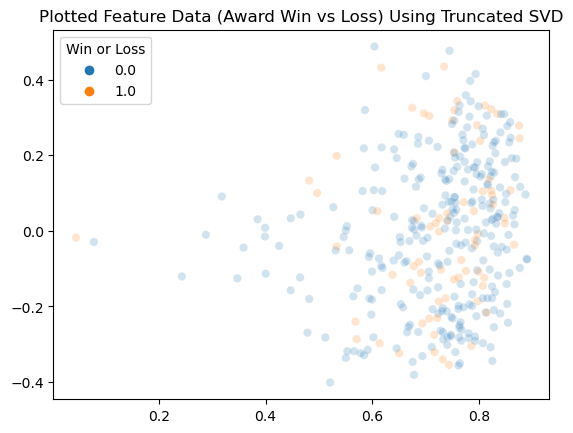

In [20]:
# Plot the feature data, default: 2 dimensional truncated SVD
features_reduced = TruncatedSVD().fit_transform(features)
sns.scatterplot(x=features_reduced[:,0], y=features_reduced[:,1], hue=labels, alpha=0.2)
plt.title('Plotted Feature Data (Award Win vs Loss) Using Truncated SVD')
plt.show()

## Create Chunks of Tokens out of the Paragraphs

Since there is a significant discrepancy between the lengths of the shortest "paragraph" and the longest "paragraph", we felt like creating standardized chunks of tokens to feed into our vectorizer could help normalize out vectors and provide more informative outputs.

In [21]:
# Create a topic model based on chunking with chunk size 200 tokens

def generate_chunks(paragraphs, movie, year, chunk_size=200):
    chunks = []
    chunk_movie_name = []
    chunk_year = []

    for i in range(len(paragraphs)):
        text = paragraphs.iloc[i]  # Extract the text from the Series
        newsletter_type = movie.iloc[i]
        date = year.iloc[i]

        # Split the text into paragraphs using '\n'
        text_paragraphs = text.split('\n')

        current_chunk = []
        current_chunk_movie_name = []

        for paragraph in text_paragraphs:
            # Check if the length of the paragraph exceeds the chunk size
            if len(paragraph) > chunk_size:
                chunks.append(paragraph)
                chunk_movie_name.append(newsletter_type)
                chunk_year.append(date)
            else:
                # If not, add the paragraph to the current chunk
                current_chunk.append(paragraph)
                current_chunk_movie_name.append(newsletter_type)

                # Check if the current chunk size exceeds the specified limit
                if len(' '.join(current_chunk)) > chunk_size:
                    chunks.append(' '.join(current_chunk))
                    chunk_year.extend([date])
                    chunk_movie_name.append(newsletter_type)
                    current_chunk = []
                    current_chunk_movie_name = []

        # Add any remaining paragraphs to the last chunk
        if current_chunk:
            chunks.append(' '.join(current_chunk))
            chunk_year.extend([date])
            chunk_movie_name.append(newsletter_type)

    return chunks, chunk_movie_name, chunk_year

# Generate chunks
text_chunks, chunk_movie_name, chunk_year = generate_chunks(movie_subtitles_df['text'], movie_subtitles_df['name'], movie_subtitles_df['years'])

In [24]:
# Vectorize chunked texts
X_chunked = tfidf_vectorizer.fit_transform(text_chunks)

# 3. Unsupervised Cluster Analysis

An initial unsupervised cluster analysis was performed to identify any discernible patterns in the data prior to further processing. Potential areas of pattern appearance are hypothesized to potentially be: winners/losers, movie release time period, and differences in sentiment.

First, we used the elbow method to try and identify the optimal number of clusters for which to perform the KMeans cluster analysis. For each value of K, we are calculating WCSS (Within-Cluster Sum of Square). WCSS is the sum of the squared distance between each point and the centroid in a cluster.

In [25]:
# # Using the elbow method to find the optimal number of clusters
# # Referenced: https://www.analyticsvidhya.com/blog/2021/01/in-depth-intuition-of-k-means-clustering-algorithm-in-machine-learning/

# wcss = [] 
# t0 = time.time()
# for i in range(1, 20): 
#     kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
#     kmeans.fit(X_chunked) 
#     wcss.append(kmeans.inertia_)
# t1 = time.time()
    
# print("Plotting the Elbow curve took:{:.1f}s ".format(t1-t0))

# # Plotting the Elbow Curve
# plt.figure(figsize=(8, 6))
# plt.plot(range(1, 20), wcss, marker='o', linestyle='-', color='b')
# plt.title('Elbow Method for Optimal K')
# plt.xlabel('Number of Clusters (K)')
# plt.ylabel('Within-Cluster-Sum-of-Squares (WCSS)')
# plt.show()

In [26]:
# y_pred = KMeans(n_clusters=2, n_init='auto').fit_predict(X_chunked)

In [27]:
# # Plotting function
# def plot_compare(X, labels, title, alpha=0.2):
#     '''
#     Takes an array of object data, a list of cluster labels, a title string, and an optional alpha value.
#     Reduces dimensions to 2 if necessary and plots the clustering with and without coloring by label.
#     Returns nothing.
#     '''
#     if X.shape[1] > 2:
#         svd = TruncatedSVD(n_components=3)
#         X_2d = svd.fit_transform(X)
#     else:
#         X_2d = X

#     # initialize figsize in prompt
#     plt.figure(figsize=(12, 6))

#     # left subplot, alpha value in function cell
#     plt.subplot(121)
#     plt.scatter(X_2d[:, 0], X_2d[:, 1], alpha=alpha)
#     plt.title("Dimension-Reduced Unclustered Data")

#     # right subplot, same coordinate data and supplied cluster labels, alpha value in function cell
#     plt.subplot(122)
#     plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, alpha=alpha)
#     plt.title("Data with Clustering")

#     # Set the common title for the entire figure
#     plt.title(title)

In [28]:
# # plot resulting clustering
# plot_compare(X_chunked, y_pred, 'k-Means Clustering with 3 Groups on Vectorized Movie Data')

Since the Within-Cluster-Sum-of-Squares (WCSS) does not seem to show a clear elbow during the KMeans analysis, we realized that KMeans might not be the best algorithm to try and determine patterns or clusters in the data. Since there is no distinct elbow, interpretation is also much less straightforward. Therefore, it is difficult to try to support or reject the hypotheses set out at the onset of the KMeans analysis. 

# 4. Baseline Supervised Classification Task for Winner vs Loser Classification

We aimed to apply two commonly used supervised classification methods (Logistic Regression and Random Forest) to set a baseline understanding of whether classifying movies into winner or loser categories for the Academy Awards Best Original Screenplay was possible.

## Logistic Regression

## Random Forest

# 5. Sentiment Analysis over the decades

For this analysis, we will be looking into the different sentiments within the decades, but also within the winners and losers of our dataset. 

In [29]:
#decades 
# twenties = movie_subtitles_df[(movie_subtitles_df['Year'] >= '1920') & (movie_subtitles_df['Year'] < '1930')]
# thirties = movie_subtitles_df[(movie_subtitles_df['Year'] >= '1930') & (movie_subtitles_df['Year'] < '1940')]
fourties = movie_subtitles_df[(movie_subtitles_df['years'] >= '1940') & (movie_subtitles_df['years'] < '1950')]
fifties = movie_subtitles_df[(movie_subtitles_df['years'] >= '1950') & (movie_subtitles_df['years'] < '1960')]
sixties = movie_subtitles_df[(movie_subtitles_df['years'] >= '1960') & (movie_subtitles_df['years'] < '1970')]
seventies = movie_subtitles_df[(movie_subtitles_df['years'] >= '1970') & (movie_subtitles_df['years'] < '1980')]
eighties = movie_subtitles_df[(movie_subtitles_df['years'] >= '1980') & (movie_subtitles_df['years'] < '1990')]
ninties = movie_subtitles_df[(movie_subtitles_df['years'] >= '1990') & (movie_subtitles_df['years'] < '2000')]
twenty = movie_subtitles_df[(movie_subtitles_df['years'] >= '2000') & (movie_subtitles_df['years'] < '2010')]
twenty_ten = movie_subtitles_df[(movie_subtitles_df['years'] >= '2010') & (movie_subtitles_df['years'] < '2020')]

In [30]:
years = [fourties, fifties, sixties, seventies, eighties, ninties, twenty, twenty_ten]

In [31]:
fourties.head(1)

,name,text,years,Movie Name,Similarity Calc Name,Win or Loss,tokenized_text,num_tokens
231,Foreign.Correspondent.1940.1080p.BluRay.x265-R...,\nWhat's new? \n- Same old daily bunkeroo. \n\...,1940,Foreign Correspondent,Foreign Correspondent,0.0,"[What, 's, new, ?, -, Same, old, daily, bunker...",17288


In [32]:
def sentiment_score(vader, text_string, name):
    sentiment_dict = vader.polarity_scores(text_string)
    overall_sentiment = 'positive' if sentiment_dict['compound'] >= 0.05 else 'negative' if sentiment_dict['compound'] <= -0.05 else 'neutral'
    # print("Movie:",name)
    # print("neg:      ",sentiment_dict['neg'])
    # print("neu:      ",sentiment_dict['neu'])
    # print("post:      ",sentiment_dict['pos'])
    # print("comp:      ",sentiment_dict['compound'])
    # print("overall sentiment: ", overall_sentiment)
    return sentiment_dict['pos'], sentiment_dict['neg']

In [33]:
#compiling sentiment scores for decades 
names = [1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010]
ind = 0
# pos_list, neg_list = [], []
pos_neg = {}
for year in years:
    analyzer = SentimentIntensityAnalyzer()
    pos_list, neg_list = [], []
    for text,movie in zip(year['text'], year['Movie Name']):
        pos, neg = sentiment_score(analyzer, str(text), movie)
        pos_list.append(pos)
        neg_list.append(neg)
    pos_neg[f"{names[ind]}_pos"] = pos_list
    pos_neg[f"{names[ind]}_neg"] = neg_list
    ind += 1

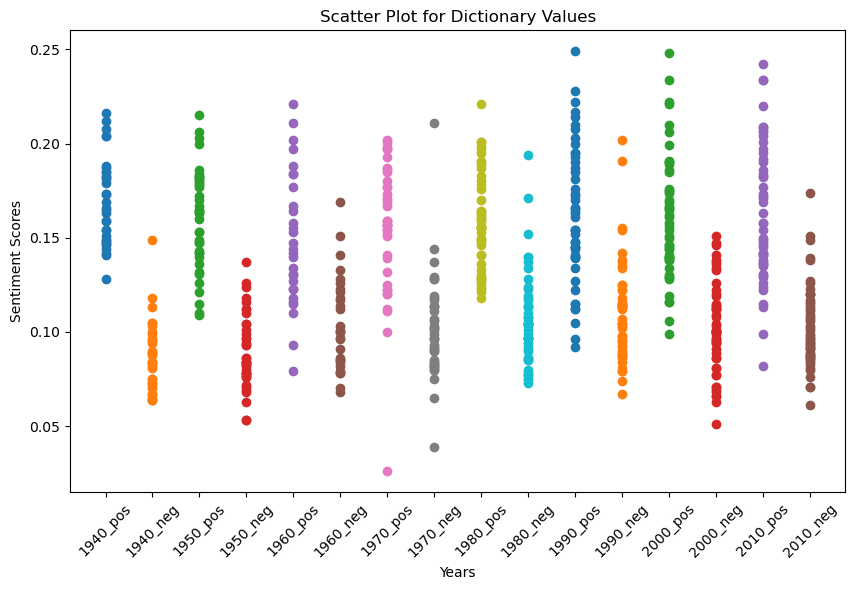

In [34]:
plt.figure(figsize=(10, 6))
plt.title('Scatter Plot for Dictionary Values')
plt.xticks(rotation=45)
plt.xlabel('Years')
plt.ylabel('Sentiment Scores')

for key, values in pos_neg.items():
    plt.scatter([key] * len(values), values, label=key)

plt.show()

In [35]:
#winners or losers 
winners = movie_subtitles_df[(movie_subtitles_df['Win or Loss'] == 1)]
losers = movie_subtitles_df[(movie_subtitles_df['Win or Loss'] == 0)]

In [36]:
names = ['wins', 'losses']
ind = 0
# pos_list, neg_list = [], []
win_loss = {}
for group in [winners, losers]:
    analyzer = SentimentIntensityAnalyzer()
    pos_list, neg_list = [], []
    for text, movie in zip(group['text'], group['Movie Name']):
        pos, neg = sentiment_score(analyzer, str(text), movie)
        pos_list.append(pos)
        neg_list.append(neg)
    win_loss[f"{names[ind]}_pos"] = pos_list
    win_loss[f"{names[ind]}_neg"] = neg_list
    ind += 1

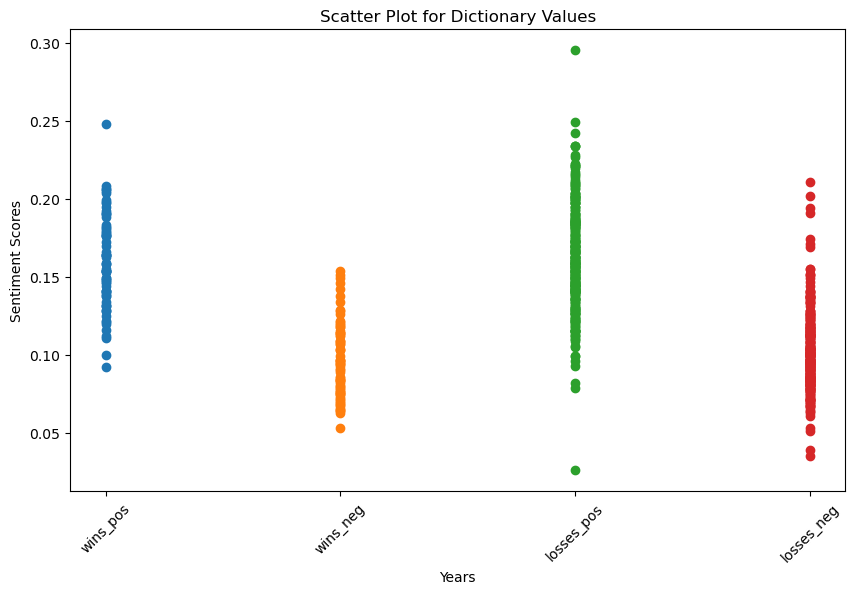

In [37]:
plt.figure(figsize=(10, 6))
plt.title('Scatter Plot for Dictionary Values')
plt.xticks(rotation=45)
plt.xlabel('Years')
plt.ylabel('Sentiment Scores')
for key, values in win_loss.items():
    plt.scatter([key] * len(values), values, label=key)

plt.show()